# Roteiro de trabalho

### Tempos dos vídeos
- (IT) Insulina Tradicional (15:00) $\rightarrow$ 900 segundos
- (GT) Glucagon Tradicional (14:57) $\rightarrow$ 897 segundos
- (IA) Insulina Ativa (19:26) $\rightarrow$ 1166 segundos
- (GA) Glucagon Ativa (20:43) $\rightarrow$ 1243 segundos

### Participante deste roteiro:
- Daniella: IT e GA

In [74]:
# imports de bibliotecas

import numpy as np
import mne
from scipy.signal import welch
import matplotlib.pyplot as plt

In [75]:
# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [76]:
# aula -> 99750 até 296500 (ga1) | 5250 até 119250 (ga2) [1243 segundos]
# teste -> 126750 até 158000 (ga2) [125 segundos]
ga = ['base/Daniella/GA/OpenBCI-RAW-2023-10-26_12-43-47.txt',
      'base/Daniella/GA/OpenBCI-RAW-2023-10-26_13-06-25.txt']
ga_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in ga]
data_ga = np.concatenate((ga_ob[0][99750:296501,:], ga_ob[1][5250:119250,:]))
data_ga_test = ga_ob[1][126750:158001,:]

X = {
    'ga': mne.io.RawArray(data_ga.T, info),
    'ga_test': mne.io.RawArray(data_ga_test.T, info),
}

Creating RawArray with float64 data, n_channels=8, n_times=310751
    Range : 0 ... 310750 =      0.000 ...  1243.000 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=31251
    Range : 0 ... 31250 =      0.000 ...   125.000 secs
Ready.


In [77]:
# filtragem de todos os dados

for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

In [78]:
import sys

sr = 250            # taxa de amostragem
jump = 5            # 5 segundos de buffer
size = sr * jump    # quantidade de pontos avaliados

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

total_pc = {}
data_names = ('ga', 'ga_test')
for k, data in enumerate(X.values()):
    results = [0, 0, 0, 0]
    for i in range(0, len(data)-1, sr):
        # Isso faz parte da TAREFA 1 explicada logo abaixo.
        # Para aplicar o set_eeg_reference, é necessário que os dados
        # estejam no objeto RawArray, que é o objeto que contém o método.
        # O slice deve ser obtido diretamente do objeto MNE, tendo que 
        # nesse caso modificar todos o laço de controle.
        cut = data.get_data(start=i, stop=i+size)
        # Número de pontos por segmento
        nperseg = 128
        # Quantidade de sobreposição entre segmentos
        noverlap = nperseg // 2
        
        freqs, psd = welch(cut, fs=sr, nperseg=nperseg, noverlap=noverlap)
        
        # TAREFA 1 (APLICANDO UM FILTRO ESPACIAL NO DADOS)
        # realizando a média dos 8 eletrodos
        # no caso do trabalho, analizar os canais separadamente.
        #   Para isso, vamos aplicar o filtro espacial, no qual
        #   podemos utilizar algoritmos específicos para a análise
        #   de EEG utilizando o CAR (Common Average Reference).
        #   Na biblioteca MNE existe o método set_eeg_reference, que
        #       pode ser utilizado para aplicar o filtro espacial.
        X = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calcular a potência em cada banda de frequência por meio da integração da PSD
        bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
        # calculando a pontuação de cada banda para mostrar a porcentagem futura
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages

print(total_pc)

<RawArray | 8 x 310751 (1243.0 s), ~19.0 MB, data loaded>
<RawArray | 8 x 31251 (125.0 s), ~1.9 MB, data loaded>
{'ga': [19.31, 0.0, 74.5, 6.19], 'ga_test': [44.0, 0.0, 48.0, 8.0]}


**Tarefa 2**: Observar por meio dos códigos, os 3 principais rítmos de interesse (Theta, Beta e Gama), com tempos mais específicos do experimento. Ou seja, até o momento, observamos as porcentagens olhando para todo experimento. Então mesmo obtendo um valor de Beta às vezes baixo, em algum momento considerável da aula assistida, ele pode estar alto. Faça uma análise mais detalhada desses momentos.

Mostre também gráficos no domínio da frequência e/ou espectrograma.

Observação: Para descobrir os segmentos de interesse, deve-se analisar os dados diretamente no software OpenBCI GUI. Posteriormente, pegue os mesmas faixas de tempo, e realize os recortes no código em python para constar a prova de conceito.

Mostrando os gráficos de barra dos resultados.

In [79]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem da potência em cada banda de frequência')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem durante a atividade')

    # Exibir o gráfico
    plt.show()

Aplicando os valores de porcentagens obtidos na função de gráfico

Glucagon Ativa


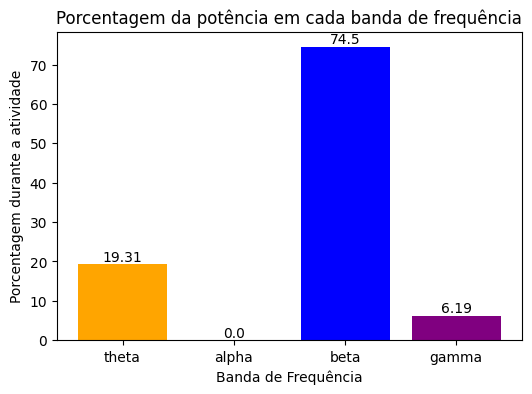

Glucagon Ativa - Teste


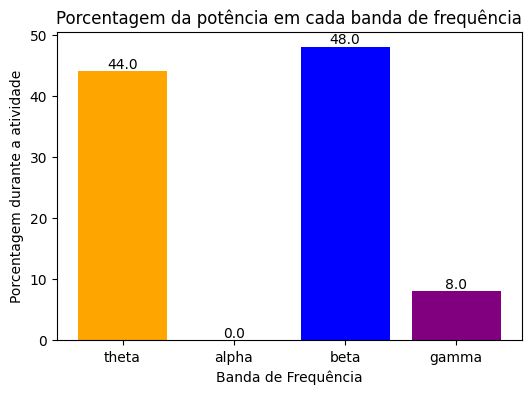

In [80]:
print('Glucagon Ativa')
plot_bar(total_pc['ga'])
print('Glucagon Ativa - Teste')
plot_bar(total_pc['ga_test'])